In [12]:
# load the nessacary modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import PIL
from google.colab import files
import random
%matplotlib inline

In [13]:
# import the classification model, segmenation model stored in h5 extension
# labels is the grouth truth of brain tumor class
# classifier is the clasification model
# model_seg is the segmentation model
labels = np.load('/content/drive/MyDrive/Colab Notebooks/Dataset/labels.npy')
classifier_model = load_model('/content/drive/MyDrive/Colab Notebooks/Dataset/vgg16_classifier.h5')
model_seg = load_model('/content/drive/MyDrive/Colab Notebooks/Dataset/brain_tumor_segmentation_acc_91.h5', compile=False)

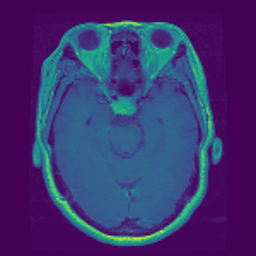

In [14]:
# image_path is the path of image that need to test
image_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/Tumor_Images/content/Tumor_Images/12.png"
image = cv2.imread(image_path)
# d = (256,256)
# image = cv2.resize(image, d)
# cv2.imwrite('image.jpg', image)
PIL.Image.open(image_path) # open function in PIL is used to view the image

In [15]:
mask_path = '/content/drive/MyDrive/Colab Notebooks/Dataset/Mask_Images/content/Mask_Images/12.png'

In [16]:
# converting image with 3 channels RGB and saving the new image
import cv2
import numpy as np
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img2 = np.zeros_like(img)
img2[:,:,0] = gray
img2[:,:,1] = gray
img2[:,:,2] = gray
cv2.imwrite('1.jpg', img2)

True

Classification of the Brain Tumor

In [17]:
# convering the new image into size (224, 224)
image_path = '/content/1.jpg'
IMG_SIZE = 224
img_array = cv2.imread(image_path)
new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE), 3) 
new_array = np.array(new_array).reshape(-1,IMG_SIZE, IMG_SIZE)
print(new_array.shape)
new_array = new_array/255.0  
new_array = new_array.reshape(-1,224, 224, 3)

(3, 224, 224)


Predicting the class of test MRI image

In [18]:
pred = classifier_model.predict(new_array)
pred = np.argmax(pred, axis=1)
print("Predicted type of the brain tumor: ")
if pred == 1:
    print("meningioma")
elif pred == 2:
    print("glioma")
else:
    print("pituitary")

Predicted type of the brain tumor: 
meningioma


Ground truth of the test MRI image tumor class

In [19]:
print("Ground truth of the tumor type: ")
if labels[1] == 1:
    print("meningioma")
elif labels[1] == 2:
    print("glioma")
else:
    print("pituitary")

Ground truth of the tumor type: 
meningioma


In [20]:
image_id = []
has_mask = []
mask = []

Preprocessing the same image for segmentation model

In [21]:
i = image_path
img = io.imread(i)
#normalizing
img = img *1./255.
#reshaping
img = cv2.resize(img, (256,256))
# converting img into array
img = np.array(img, dtype=np.float64)
#reshaping the image from 256,256,3 to 1,256,256,3
print(img.shape)
img = np.reshape(img, (1,256,256,3))
        
#         #making prediction for tumor in image
# is_defect = model.predict(img)
        
#         #if tumour is not present we append the details of the image to the list
# if np.argmax(is_defect)==0:
#         image_id.append(i)
#         has_mask.append(0)
#         mask.append('No mask :)')
#         continue
        
        #Creating a empty array of shape 1,256,256,1
X = np.empty((1,256,256,3))
        # read the image
img = io.imread(i)
        #resizing the image and coverting them to array of type float64
img = cv2.resize(img, (256,256))
img = np.array(img, dtype=np.float64)
        
        # standardising the image
img -= img.mean()
img /= img.std()
        #converting the shape of image from 256,256,3 to 1,256,256,3
X[0,] = img
        
        #make prediction of mask
predict = model_seg.predict(X)
        
        # if sum of predicted mask is 0 then there is not tumour
if predict.round().astype(int).sum()==0:
        image_id.append(i)
        has_mask.append(0)
        mask.append('No mask :)')
else:
        #if the sum of pixel values are more than 0, then there is tumour
        image_id.append(i)
        has_mask.append(1)
        mask.append(predict)

print(img.shape)
print(has_mask)

(256, 256, 3)
(256, 256, 3)
[1]


Text(0.5, 1.0, 'Predicted MRI Tumor position')

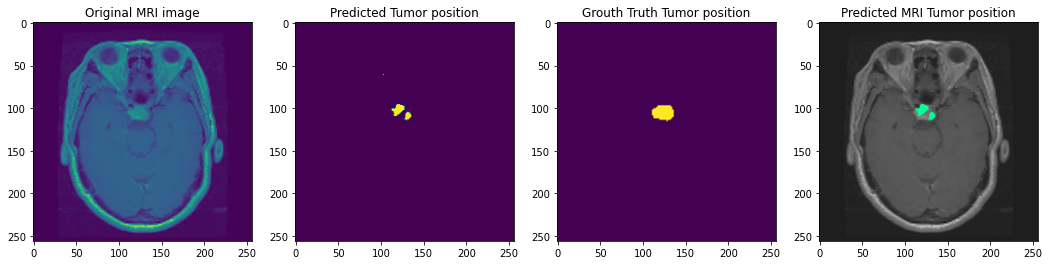

In [22]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (18, 6))

# Original Tumor MRI
img = io.imread(image_id[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ax1.imshow(img)
ax1.set_title("Original MRI image")

# Predicted Tumor position
pred = np.array(mask[0]).squeeze().round()
ax2.imshow(pred)
ax2.set_title("Predicted Tumor position")

# Grouth Truth Tumor position
mask = io.imread(mask_path)
ax3.imshow(mask)
ax3.set_title("Grouth Truth Tumor position")

# Predicted Tumor position in MRI
dim = (256, 256)
img = cv2.resize(img, dim)
img+3
img_ = io.imread(image_id[0])
dim = (256, 256)
img_ = cv2.resize(img_, dim)
img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
img_[pred==1] = (0,255,150)
ax4.imshow(img_)
ax4.set_title("Predicted MRI Tumor position")
